In [ ]:
!pip -q install opendatasets lime shap

import os, time, shutil, itertools, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization,
                                     Dense, GlobalAveragePooling2D)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

print("modules loaded")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 14.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
modules loaded


In [ ]:
import opendatasets as od

# Kaggle dataset
od.download("https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/data")

DATA_ROOT = "/content/brain-tumor-mri-dataset"
TRAIN_DIR = os.path.join(DATA_ROOT, "Training")
TEST_DIR  = os.path.join(DATA_ROOT, "Testing")

print(" dataset exists:", os.path.isdir(TRAIN_DIR), os.path.isdir(TEST_DIR))

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mahmoudhamad2000
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset


100%|██████████| 149M/149M [00:00<00:00, 1.65GB/s]

 dataset exists: True True


# Build DataFrame (paths + labels)

In [ ]:
data_paths = [TRAIN_DIR, TEST_DIR]

images, labels = [], []
for data_path in data_paths:
    for subfolder in os.listdir(data_path):
        subfolder_path = os.path.join(data_path, subfolder)
        if not os.path.isdir(subfolder_path):
            continue
        for image_filename in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, image_filename)
            images.append(image_path)
            labels.append(subfolder)

data = pd.DataFrame({"image": images, "label": labels})
print("data shape:", data.shape)
data.head()

data shape: (7023, 2)


image       label
0  /content/brain-tumor-mri-dataset/Training/meni...  meningioma
1  /content/brain-tumor-mri-dataset/Training/meni...  meningioma
2  /content/brain-tumor-mri-dataset/Training/meni...  meningioma
3  /content/brain-tumor-mri-dataset/Training/meni...  meningioma
4  /content/brain-tumor-mri-dataset/Training/meni...  meningioma

# Split (Train / Valid / Test) stratified

In [ ]:
strat = data["label"]
train_df, dummy_df = train_test_split(
    data, train_size=0.85, shuffle=True, random_state=123, stratify=strat
)

strat = dummy_df["label"]
valid_df, test_df = train_test_split(
    dummy_df, train_size=0.5, shuffle=True, random_state=123, stratify=strat
)

print("Training:", train_df.shape)
print("Validation:", valid_df.shape)
print("Test:", test_df.shape)


Training: (5969, 2)
Validation: (527, 2)
Test: (527, 2)


# Generators (Base CNN scaling + Augmentation)

In [ ]:
batch_size = 32
img_size = (256, 256)
input_shape = (img_size[0], img_size[1], 3)

tr_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode="constant",
    cval=0
)

ts_gen = ImageDataGenerator(rescale=1./255)

train_gen = tr_gen.flow_from_dataframe(
    train_df, x_col="image", y_col="label",
    target_size=img_size, class_mode="categorical", color_mode="rgb",
    shuffle=True, batch_size=batch_size
)

valid_gen = ts_gen.flow_from_dataframe(
    valid_df, x_col="image", y_col="label",
    target_size=img_size, class_mode="categorical", color_mode="rgb",
    shuffle=False, batch_size=batch_size
)

test_gen = ts_gen.flow_from_dataframe(
    test_df, x_col="image", y_col="label",
    target_size=img_size, class_mode="categorical", color_mode="rgb",
    shuffle=False, batch_size=batch_size
)

print("class indices:", train_gen.class_indices)


Found 5969 validated image filenames belonging to 4 classes.
Found 527 validated image filenames belonging to 4 classes.
Found 527 validated image filenames belonging to 4 classes.
class indices: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


# Dataset Pie Chart | Show sample images

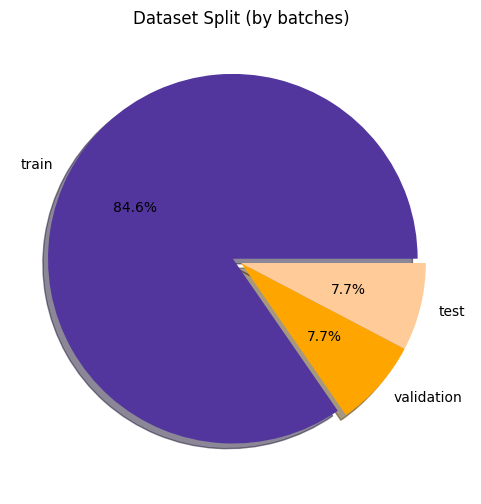

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.pie(
    [len(train_gen), len(valid_gen), len(test_gen)],
    labels=['train', 'validation', 'test'],
    autopct='%.1f%%',
    explode=(0.05, 0, 0),
    shadow=True,
    colors=["#52369d", "orange", "#ffcc99"]
)

plt.title("Dataset Split (by batches)")
plt.savefig("dataset_pie.png", dpi=300, bbox_inches="tight")
plt.show()


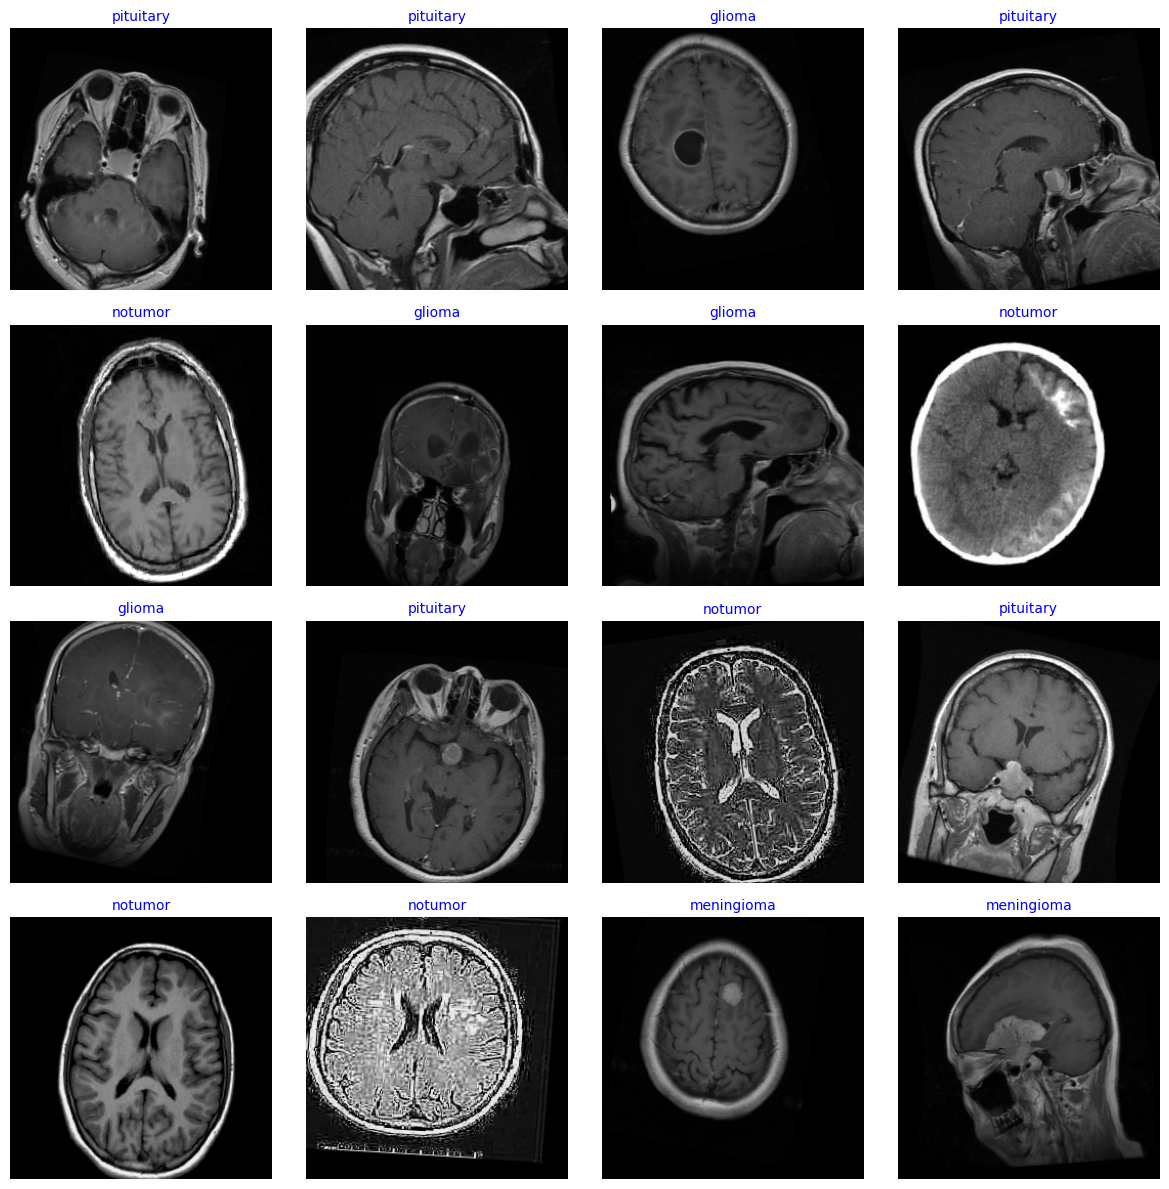

In [ ]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())

images_batch, labels_batch = next(train_gen)

plt.figure(figsize=(12, 12))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images_batch[i])
    idx = np.argmax(labels_batch[i])
    plt.title(classes[idx], fontsize=10, color="blue")
    plt.axis("off")
plt.tight_layout()
plt.show()


# Augmented (Virtual) counts

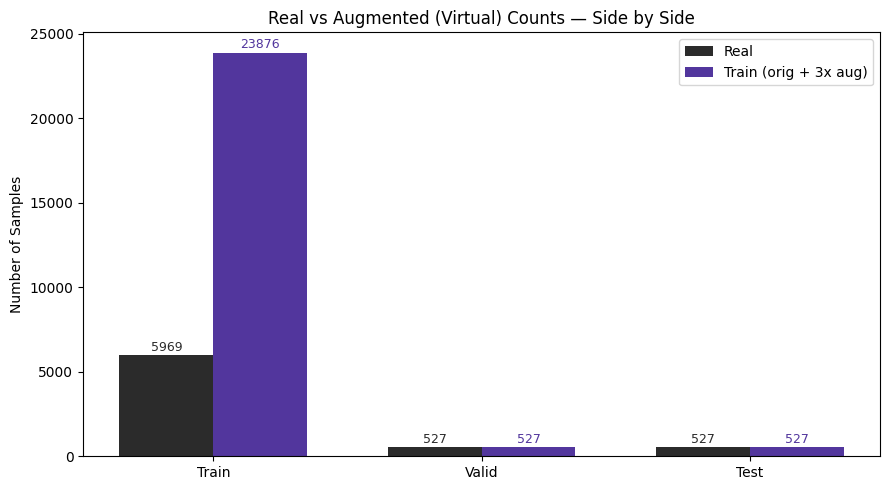

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_real_vs_aug_side_by_side(train_df, valid_df, test_df, aug_per_image=3, include_original=True):
    real_train = len(train_df)
    real_valid = len(valid_df)
    real_test  = len(test_df)

    if include_original:
        aug_train = real_train * (1 + aug_per_image)
        aug_label = f"Train (orig + {aug_per_image}x aug)"
    else:
        aug_train = real_train * aug_per_image
        aug_label = f"Train ({aug_per_image}x aug only)"

    splits = ["Train", "Valid", "Test"]
    real_counts = [real_train, real_valid, real_test]
    aug_counts  = [aug_train, real_valid, real_test]

    x = np.arange(len(splits))
    width = 0.35

    plt.figure(figsize=(9,5))

    # ✅ custom colors
    plt.bar(
        x - width/2, real_counts, width,
        label="Real",
        color="#2b2b2b"
    )
    plt.bar(
        x + width/2, aug_counts, width,
        label=aug_label,
        color="#52369d"
    )

    plt.xticks(x, splits)
    plt.ylabel("Number of Samples")
    plt.title("Real vs Augmented (Virtual) Counts — Side by Side")

    # value labels
    max_val = max(max(real_counts), max(aug_counts))
    for i, v in enumerate(real_counts):
        plt.text(i - width/2, v + max_val*0.01, str(v),
                 ha='center', fontsize=9, color="#2b2b2b")
    for i, v in enumerate(aug_counts):
        plt.text(i + width/2, v + max_val*0.01, str(v),
                 ha='center', fontsize=9, color="#52369d")

    plt.legend()
    plt.tight_layout()
    plt.show()

# Example
plot_real_vs_aug_side_by_side(
    train_df, valid_df, test_df,
    aug_per_image=3,
    include_original=True
)


# Base CNN Model + Train

In [ ]:
base_model = Sequential([
    Input(shape=input_shape),

    Conv2D(32, (3,3), activation='relu', padding='same'),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    GlobalAveragePooling2D(),

    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.0005)),
    Dropout(0.5),

    Dense(len(train_gen.class_indices), activation='softmax')
])

base_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 650,916 (2.48 MB)

 Trainable params: 649,956 (2.48 MB)

 Non-trainable params: 960 (3.75 KB)

# Callbacks + Train Base CNN

In [ ]:
run_id = time.strftime("%Y%m%d-%H%M%S")  # اسم فريد لكل تشغيل
print(" RUN ID:", run_id)

class StopAt95(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        if logs.get("val_accuracy", 0) > 0.95:
            print("\n Reached 95% val_accuracy, stopping training.")
            self.model.stop_training = True

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True, verbose=1)

base_ckpt = ModelCheckpoint(
    filepath=f"best_base_cnn_{run_id}.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

base_model.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_base = base_model.fit(
    train_gen,
    epochs=30,
    validation_data=valid_gen,
    callbacks=[StopAt95(), reduce_lr, early_stop, base_ckpt],
    verbose=1
)


 RUN ID: 20260107-163831


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.6376 - loss: 1.0183
Epoch 1: val_loss improved from inf to 3.00228, saving model to best_base_cnn_20260107-163831.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 133s 596ms/step - accuracy: 0.6379 - loss: 1.0175 - val_accuracy: 0.2505 - val_loss: 3.0023 - learning_rate: 5.0000e-04
Epoch 2/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.7869 - loss: 0.6532
Epoch 2: val_loss did not improve from 3.00228
187/187 ━━━━━━━━━━━━━━━━━━━━ 94s 501ms/step - accuracy: 0.7870 - loss: 0.6530 - val_accuracy: 0.2505 - val_loss: 4.6073 - learning_rate: 5.0000e-04
Epoch 3/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.8490 - loss: 0.5225
Epoch 3: val_loss improved from 3.00228 to 2.08599, saving model to best_base_cnn_20260107-163831.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 94s 501ms/step - accuracy: 0.8490 - loss: 0.5225 - val_accuracy: 0.5047 - val_loss: 2.0860 - learning_rate: 5.0000e-04
Epoch 4/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.8513 - loss: 0.4943
Epoch 4: val_loss improved from 2.08599 to 1.30855, saving model to best_base_cnn_20260107-163831.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 93s 499ms/step - accuracy: 0.8514 - loss: 0.4941 - val_accuracy: 0.5920 - val_loss: 1.3085 - learning_rate: 5.0000e-04
Epoch 5/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.8805 - loss: 0.4134
Epoch 5: val_loss improved from 1.30855 to 0.53774, saving model to best_base_cnn_20260107-163831.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 94s 500ms/step - accuracy: 0.8805 - loss: 0.4134 - val_accuracy: 0.8273 - val_loss: 0.5377 - learning_rate: 5.0000e-04
Epoch 6/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.8954 - loss: 0.3835
Epoch 6: val_loss did not improve from 0.53774
187/187 ━━━━━━━━━━━━━━━━━━━━ 94s 501ms/step - accuracy: 0.8954 - loss: 0.3834 - val_accuracy: 0.6319 - val_loss: 1.0183 - learning_rate: 5.0000e-04
Epoch 7/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.9095 - loss: 0.3407
Epoch 7: val_loss improved from 0.53774 to 0.53277, saving model to best_base_cnn_20260107-163831.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 93s 498ms/step - accuracy: 0.9095 - loss: 0.3408 - val_accuracy: 0.8273 - val_loss: 0.5328 - learning_rate: 5.0000e-04
Epoch 8/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.9140 - loss: 0.3134
Epoch 8: val_loss did not improve from 0.53277
187/187 ━━━━━━━━━━━━━━━━━━━━ 93s 497ms/step - accuracy: 0.9140 - loss: 0.3135 - val_accuracy: 0.7419 - val_loss: 0.9381 - learning_rate: 5.0000e-04
Epoch 9/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.9065 - loss: 0.3233
Epoch 9: val_loss did not improve from 0.53277
187/187 ━━━━━━━━━━━━━━━━━━━━ 93s 497ms/step - accuracy: 0.9065 - loss: 0.3233 - val_accuracy: 0.6945 - val_loss: 1.2258 - learning_rate: 5.0000e-04
Epoch 10/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.9202 - loss: 0.2824
Epoch 10: val_loss improved from 0.53277 to 0.29128, saving model to best_base_cnn_20260107-163831.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 94s 500ms/step - accuracy: 0.9202 - loss: 0.2824 - val_accuracy: 0.9089 - val_loss: 0.2913 - learning_rate: 5.0000e-04
Epoch 11/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.9261 - loss: 0.2694
Epoch 11: val_loss improved from 0.29128 to 0.21763, saving model to best_base_cnn_20260107-163831.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 93s 499ms/step - accuracy: 0.9261 - loss: 0.2693 - val_accuracy: 0.9374 - val_loss: 0.2176 - learning_rate: 5.0000e-04
Epoch 12/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.9318 - loss: 0.2465
Epoch 12: val_loss did not improve from 0.21763
187/187 ━━━━━━━━━━━━━━━━━━━━ 94s 501ms/step - accuracy: 0.9318 - loss: 0.2465 - val_accuracy: 0.5465 - val_loss: 1.3999 - learning_rate: 5.0000e-04
Epoch 13/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.9402 - loss: 0.2256
Epoch 13: val_loss did not improve from 0.21763
187/187 ━━━━━━━━━━━━━━━━━━━━ 93s 499ms/step - accuracy: 0.9402 - loss: 0.2256 - val_accuracy: 0.7381 - val_loss: 0.6860 - learning_rate: 5.0000e-04
Epoch 14/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.9412 - loss: 0.2196
Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 14: val_loss did not improve from 0.21763
187/187 ━━━━━━━━━━━━━━━━━━━━ 93s 500ms/step - accuracy: 0.9412 - lo

187/187 ━━━━━━━━━━━━━━━━━━━━ 93s 499ms/step - accuracy: 0.9637 - loss: 0.1697 - val_accuracy: 0.9753 - val_loss: 0.1662 - learning_rate: 2.5000e-04
Restoring model weights from the end of the best epoch: 15.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9395 - loss: 0.2026
 Base CNN Test Loss: 0.22833247482776642
 Base CNN Test Acc : 0.9354838728904724


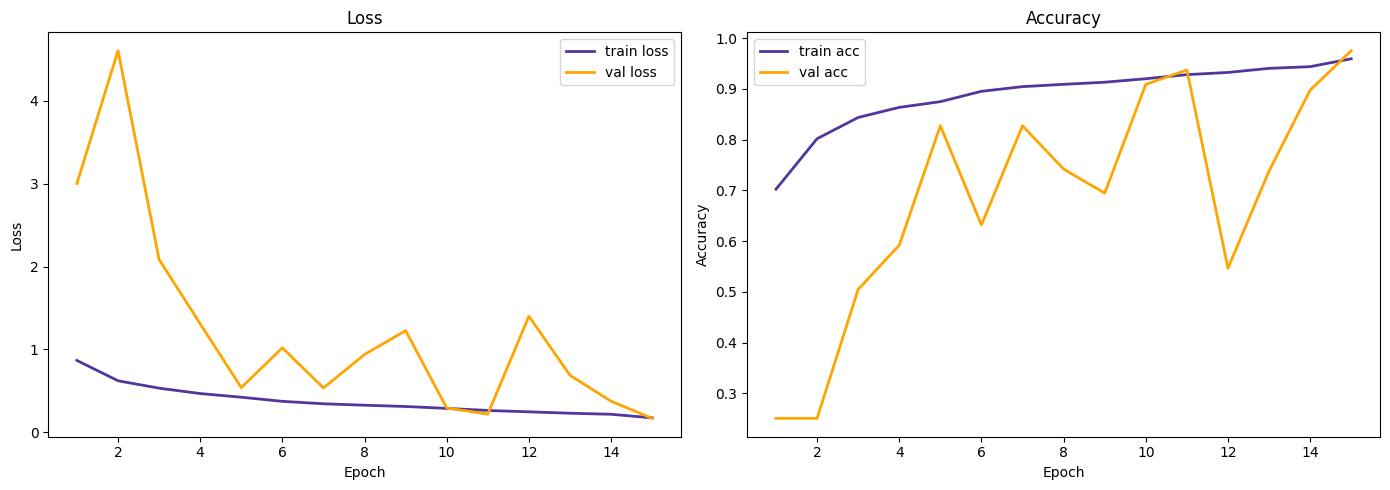

In [ ]:
test_loss, test_acc = base_model.evaluate(test_gen, verbose=1)
print(" Base CNN Test Loss:", test_loss)
print(" Base CNN Test Acc :", test_acc)

tr_acc  = history_base.history['accuracy']
tr_loss = history_base.history['loss']
val_acc  = history_base.history['val_accuracy']
val_loss = history_base.history['val_loss']

epochs = range(1, len(tr_acc) + 1)

TRAIN_COLOR = "#52369d"
VAL_COLOR   = "orange"

plt.figure(figsize=(14,5))

# Loss
plt.subplot(1,2,1)
plt.plot(epochs, tr_loss, label="train loss", color=TRAIN_COLOR, linewidth=2)
plt.plot(epochs, val_loss, label="val loss", color=VAL_COLOR, linewidth=2)
plt.legend()
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Accuracy
plt.subplot(1,2,2)
plt.plot(epochs, tr_acc, label="train acc", color=TRAIN_COLOR, linewidth=2)
plt.plot(epochs, val_acc, label="val acc", color=VAL_COLOR, linewidth=2)
plt.legend()
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()


In [ ]:
# Fine-tune Base CNN (continue training with smaller LR)
base_model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Starting Base CNN Fine-Tuning (small LR)...")
history_fine = base_model.fit(
    train_gen,
    epochs=10,
    validation_data=valid_gen,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print("Final Evaluation:")
base_model.evaluate(test_gen, verbose=1)

Starting Base CNN Fine-Tuning (small LR)...
Epoch 1/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 107s 530ms/step - accuracy: 0.9645 - loss: 0.1588 - val_accuracy: 0.9772 - val_loss: 0.1167 - learning_rate: 1.0000e-05
Epoch 2/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 94s 502ms/step - accuracy: 0.9704 - loss: 0.1423 - val_accuracy: 0.9829 - val_loss: 0.1121 - learning_rate: 1.0000e-05
Epoch 3/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 93s 495ms/step - accuracy: 0.9730 - loss: 0.1432 - val_accuracy: 0.9810 - val_loss: 0.1098 - learning_rate: 1.0000e-05
Epoch 4/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 93s 498ms/step - accuracy: 0.9713 - loss: 0.1326 - val_accuracy: 0.9848 - val_loss: 0.1104 - learning_rate: 1.0000e-05
Epoch 5/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 93s 498ms/step - accuracy: 0.9708 - loss: 0.1364 - val_accuracy: 0.9772 - val_loss: 0.1174 - learning_rate: 1.0000e-05
Epoch 6/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.9665 - loss: 0.1429
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-

[0.1324395090341568, 0.9715369939804077]

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9678 - loss: 0.1222
 Base CNN (Fine-Tuned) Test Loss: 0.1324395090341568
 Base CNN (Fine-Tuned) Test Acc : 0.9715369939804077


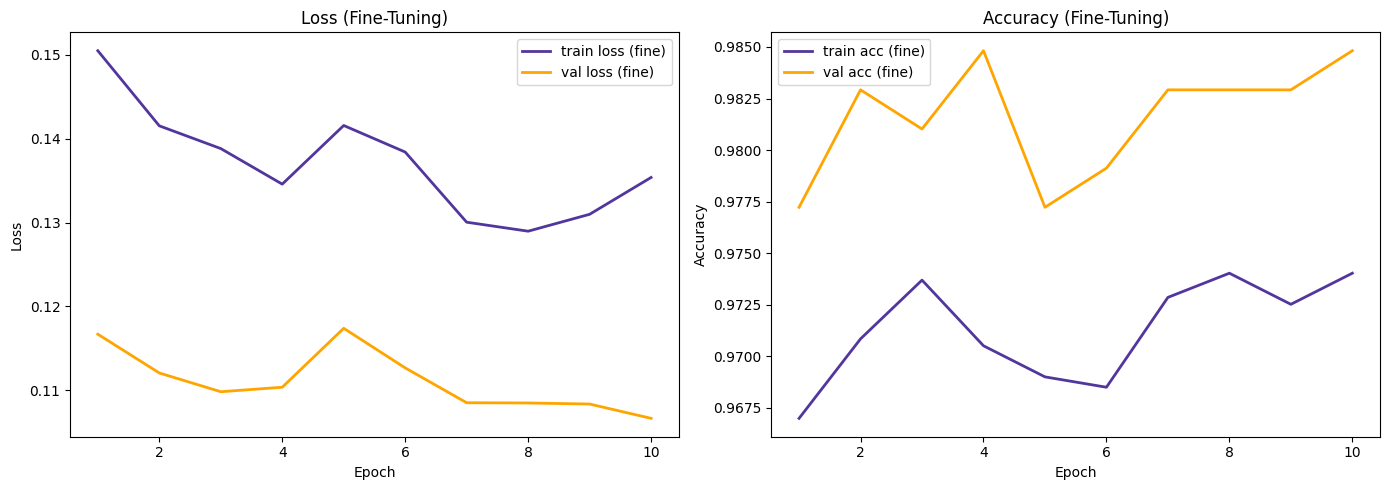

In [ ]:
test_loss, test_acc = base_model.evaluate(test_gen, verbose=1)
print(" Base CNN (Fine-Tuned) Test Loss:", test_loss)
print(" Base CNN (Fine-Tuned) Test Acc :", test_acc)

#  Curves from Fine-Tuning history
tr_acc   = history_fine.history['accuracy']
tr_loss  = history_fine.history['loss']
val_acc  = history_fine.history['val_accuracy']
val_loss = history_fine.history['val_loss']

epochs = range(1, len(tr_acc) + 1)

TRAIN_COLOR = "#52369d"
VAL_COLOR   = "orange"

plt.figure(figsize=(14,5))

# Loss
plt.subplot(1,2,1)
plt.plot(epochs, tr_loss, label="train loss (fine)", color=TRAIN_COLOR, linewidth=2)
plt.plot(epochs, val_loss, label="val loss (fine)", color=VAL_COLOR, linewidth=2)
plt.legend()
plt.title("Loss (Fine-Tuning)")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Accuracy
plt.subplot(1,2,2)
plt.plot(epochs, tr_acc, label="train acc (fine)", color=TRAIN_COLOR, linewidth=2)
plt.plot(epochs, val_acc, label="val acc (fine)", color=VAL_COLOR, linewidth=2)
plt.legend()
plt.title("Accuracy (Fine-Tuning)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()

# Pretrained Models (ResNet50 / VGG16 / MobileNetV2 / DenseNet121)


In [ ]:
from tensorflow.keras.applications import ResNet50, VGG16, MobileNetV2, DenseNet121
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mn_preprocess
from tensorflow.keras.applications.densenet import preprocess_input as dn_preprocess

num_classes = len(train_gen.class_indices)
class_names = list(train_gen.class_indices.keys())
print(" Classes:", class_names)


 Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


Generators for pretrained (with preprocessing_function)

In [ ]:
def create_generators(preprocess_fn):
    train_datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',
        preprocessing_function=preprocess_fn
    )

    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_fn)

    train_g = train_datagen.flow_from_dataframe(
        train_df, x_col="image", y_col="label",
        target_size=img_size, class_mode="categorical", color_mode="rgb",
        shuffle=True, batch_size=batch_size
    )

    valid_g = test_datagen.flow_from_dataframe(
        valid_df, x_col="image", y_col="label",
        target_size=img_size, class_mode="categorical", color_mode="rgb",
        shuffle=False, batch_size=batch_size
    )

    test_g = test_datagen.flow_from_dataframe(
        test_df, x_col="image", y_col="label",
        target_size=img_size, class_mode="categorical", color_mode="rgb",
        shuffle=False, batch_size=batch_size
    )
    return train_g, valid_g, test_g


In [ ]:
def create_callbacks(model_name, run_id):
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1)
    early_stop = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True, verbose=1)

    ckpt_path = f"best_{model_name}_{run_id}.keras"
    checkpoint = ModelCheckpoint(ckpt_path, monitor="val_loss", save_best_only=True, verbose=1)

    return [reduce_lr, early_stop, checkpoint], ckpt_path


In [ ]:
def build_transfer_model(base, name):
    base.trainable = False
    inputs = Input(shape=input_shape)
    x = base(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation="softmax")(x)
    model = Model(inputs, outputs, name=name)
    model.compile(optimizer=Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    return model


# Train ResNet50

In [ ]:
resnet_train_gen, resnet_valid_gen, resnet_test_gen = create_generators(resnet_preprocess)

resnet_base = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
resnet_model = build_transfer_model(resnet_base, "ResNet50_brain_tumor")

resnet_callbacks, resnet_ckpt_path = create_callbacks("resnet50", run_id)

history_resnet = resnet_model.fit(
    resnet_train_gen,
    epochs=20,
    validation_data=resnet_valid_gen,
    callbacks=resnet_callbacks,
    verbose=1
)

resnet_test_loss, resnet_test_acc = resnet_model.evaluate(resnet_test_gen, verbose=1)
print(" ResNet50 Test Acc:", resnet_test_acc)


Found 5969 validated image filenames belonging to 4 classes.
Found 527 validated image filenames belonging to 4 classes.
Found 527 validated image filenames belonging to 4 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.5419 - loss: 1.1208
Epoch 1: val_loss improved from inf to 0.45201, saving model to best_resnet50_20260107-163831.keras
187/187 ━━━━━━━━━━━━━━━━━━━━ 114s 537ms/step - accuracy: 0.5426 - loss: 1.1193 - val_accuracy: 0.8387 - val_loss: 0.4520 - learning_rate: 1.0000e-04
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.8010 - loss: 0.5360
Epoch 2: val_loss improved from 0.45201 to 0.33432, saving model to best_resnet50_20260107-163831.keras
187/187 ━━━━━━━━━━━━━━━━━━━━ 83s 446ms/step - accuracy: 0.8011 - loss: 0.5358 - val_accuracy: 0.8861 - val_loss: 0.3343 - learning_rate: 1.0000e-04
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.8363 - loss: 0.4352
Epoch 3: val_loss improved from 0.33432 to 0.27775, saving model to best_resnet50_20260107-163831.keras
187/187 ━━━━━━━━━━━━━━━━━━━━ 83s 446ms/step - accuracy: 0.8364 - loss: 0.4350 - val_accuracy: 0.8975 - val_loss: 0.2777 - learning_

# Train VGG16

In [ ]:
vgg_train_gen, vgg_valid_gen, vgg_test_gen = create_generators(vgg_preprocess)

vgg_base = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
vgg_model = build_transfer_model(vgg_base, "VGG16_brain_tumor")

vgg_callbacks, vgg_ckpt_path = create_callbacks("vgg16", run_id)

history_vgg = vgg_model.fit(
    vgg_train_gen,
    epochs=20,
    validation_data=vgg_valid_gen,
    callbacks=vgg_callbacks,
    verbose=1
)

vgg_test_loss, vgg_test_acc = vgg_model.evaluate(vgg_test_gen, verbose=1)
print(" VGG16 Test Acc:", vgg_test_acc)


Found 5969 validated image filenames belonging to 4 classes.
Found 527 validated image filenames belonging to 4 classes.
Found 527 validated image filenames belonging to 4 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.3318 - loss: 3.6188
Epoch 1: val_loss improved from inf to 0.74349, saving model to best_vgg16_20260107-163831.keras
187/187 ━━━━━━━━━━━━━━━━━━━━ 102s 502ms/step - accuracy: 0.3323 - loss: 3.6132 - val_accuracy: 0.7021 - val_loss: 0.7435 - learning_rate: 1.0000e-04
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.5991 - loss: 1.1422
Epoch 2: val_loss improved from 0.74349 to 0.51800, saving model to best_vgg16_20260107-163831.keras
187/187 ━━━━━━━━━━━━━━━━━━━━ 83s 446ms/step - accuracy: 0.5993 - loss: 1.1416 - val_accuracy: 0.7913 - val_loss: 0.5180 - learning_rate: 1.0000e-04
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.6875 - loss: 0.7937
Epoch 3: val_loss improved from 0.51800 to 0.47162, saving model to best_vgg16_20260107-163831.keras
187/187 ━━━━━━━━━━━━━━━━━━━━ 84s 450ms/step - accuracy: 0.6875 - loss: 0.7935 - val_accuracy: 0.8159 - val_loss: 0.4716 - learning_rate: 1.0

# Train MobileNetV2

In [ ]:
mn_train_gen, mn_valid_gen, mn_test_gen = create_generators(mn_preprocess)

mn_base = MobileNetV2(weights="imagenet", include_top=False, input_shape=input_shape)
mn_model = build_transfer_model(mn_base, "MobileNetV2_brain_tumor")

mn_callbacks, mn_ckpt_path = create_callbacks("mobilenetv2", run_id)

history_mn = mn_model.fit(
    mn_train_gen,
    epochs=20,
    validation_data=mn_valid_gen,
    callbacks=mn_callbacks,
    verbose=1
)

mn_test_loss, mn_test_acc = mn_model.evaluate(mn_test_gen, verbose=1)
print(" MobileNetV2 Test Acc:", mn_test_acc)


Found 5969 validated image filenames belonging to 4 classes.
Found 527 validated image filenames belonging to 4 classes.
Found 527 validated image filenames belonging to 4 classes.


/tmp/ipython-input-4240345386.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mn_base = MobileNetV2(weights="imagenet", include_top=False, input_shape=input_shape)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.4824 - loss: 1.1836
Epoch 1: val_loss improved from inf to 0.51844, saving model to best_mobilenetv2_20260107-163831.keras
187/187 ━━━━━━━━━━━━━━━━━━━━ 157s 691ms/step - accuracy: 0.4831 - loss: 1.1822 - val_accuracy: 0.8254 - val_loss: 0.5184 - learning_rate: 1.0000e-04
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.7734 - loss: 0.6248
Epoch 2: val_loss improved from 0.51844 to 0.40451, saving model to best_mobilenetv2_20260107-163831.keras
187/187 ━━━━━━━━━━━━━━━━━━━━ 83s 446ms/step - accuracy: 0.7735 - loss: 0.6246 - val_accuracy: 0.8482 - val_loss: 0.4045 - learning_rate: 1.0000e-04
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.8175 - loss: 0.4983
Epoch 3: val_loss improved from 0.40451 to 0.36438, saving model to best_mobilenetv2_20260107-163831.keras
187/187 ━━━━━━━━━━━━━━━━━━━━ 83s 446ms/step - accuracy: 0.8175 - loss: 0.4982 - val_accuracy: 0.8615 - val_loss: 0.3644 - 

# Train DenseNet121

In [ ]:
dn_train_gen, dn_valid_gen, dn_test_gen = create_generators(dn_preprocess)

dn_base = DenseNet121(weights="imagenet", include_top=False, input_shape=input_shape)
dn_model = build_transfer_model(dn_base, "DenseNet121_brain_tumor")

dn_callbacks, dn_ckpt_path = create_callbacks("densenet121", run_id)

history_dn = dn_model.fit(
    dn_train_gen,
    epochs=20,
    validation_data=dn_valid_gen,
    callbacks=dn_callbacks,
    verbose=1
)

dn_test_loss, dn_test_acc = dn_model.evaluate(dn_test_gen, verbose=1)
print(" DenseNet121 Test Acc:", dn_test_acc)


Found 5969 validated image filenames belonging to 4 classes.
Found 527 validated image filenames belonging to 4 classes.
Found 527 validated image filenames belonging to 4 classes.
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.3964 - loss: 1.5468
Epoch 1: val_loss improved from inf to 0.69890, saving model to best_densenet121_20260107-163831.keras
187/187 ━━━━━━━━━━━━━━━━━━━━ 157s 679ms/step - accuracy: 0.3971 - loss: 1.5450 - val_accuracy: 0.7590 - val_loss: 0.6989 - learning_rate: 1.0000e-04
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.7086 - loss: 0.7585
Epoch 2: val_loss improved from 0.69890 to 0.50592, saving model to best_densenet121_20260107-163831.keras
187/187 ━━━━━━━━━━━━━━━━━━━━ 84s 451ms/step - accuracy: 0.7087 - loss: 0.7583 - val_accuracy: 0.8254 - val_loss: 0.5059 - learning_rate: 1.0000e-04
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.7642 - loss: 0.6141
Epoch 3: val_loss improved from 0.50592 to 0.43856, saving model to best_densenet121_20260107-163831.keras
187/187 ━━━━━━━━━━━━━━━━━━━━ 85s 452ms/step - accuracy: 0.7642 - loss: 0.6140 - val_accuracy: 0.8596 - val_loss: 0.4386 - 

Model Comparison Bar Chart

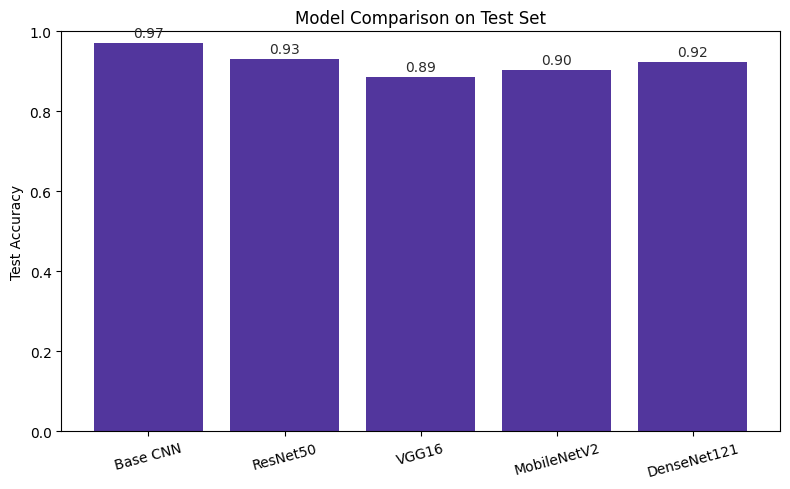

Accuracies:
Base CNN: 0.9715
ResNet50: 0.9317
VGG16: 0.8861
MobileNetV2: 0.9032
DenseNet121: 0.9222


In [ ]:
import matplotlib.pyplot as plt

base_loss, base_acc     = base_model.evaluate(test_gen, verbose=0)
resnet_loss, resnet_acc = resnet_model.evaluate(resnet_test_gen, verbose=0)
vgg_loss, vgg_acc       = vgg_model.evaluate(vgg_test_gen, verbose=0)
mn_loss, mn_acc         = mn_model.evaluate(mn_test_gen, verbose=0)
dn_loss, dn_acc         = dn_model.evaluate(dn_test_gen, verbose=0)

model_names = ["Base CNN", "ResNet50", "VGG16", "MobileNetV2", "DenseNet121"]
accuracies  = [base_acc, resnet_acc, vgg_acc, mn_acc, dn_acc]

PURPLE = "#52369d"

plt.figure(figsize=(8, 5))
plt.bar(model_names, accuracies, color=PURPLE)

plt.ylim(0, 1.0)
plt.ylabel("Test Accuracy")
plt.title("Model Comparison on Test Set")

for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.015, f"{acc:.2f}", ha='center', fontsize=10, color="#2b2b2b")

plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

print("Accuracies:")
for name, acc in zip(model_names, accuracies):
    print(f"{name}: {acc:.4f}")


# Confusion Matrix + Classification Report

Mounted at /content/drive


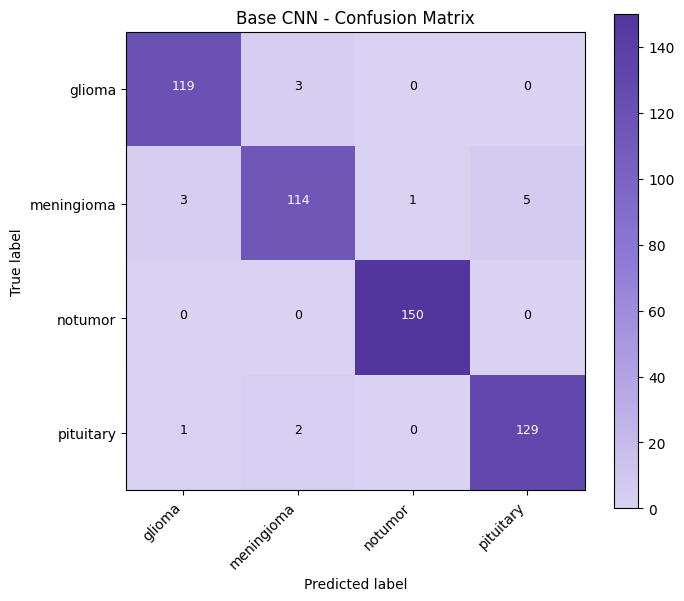


Base CNN - Confusion Matrix
              precision    recall  f1-score   support

      glioma       0.97      0.98      0.97       122
  meningioma       0.96      0.93      0.94       123
     notumor       0.99      1.00      1.00       150
   pituitary       0.96      0.98      0.97       132

    accuracy                           0.97       527
   macro avg       0.97      0.97      0.97       527
weighted avg       0.97      0.97      0.97       527



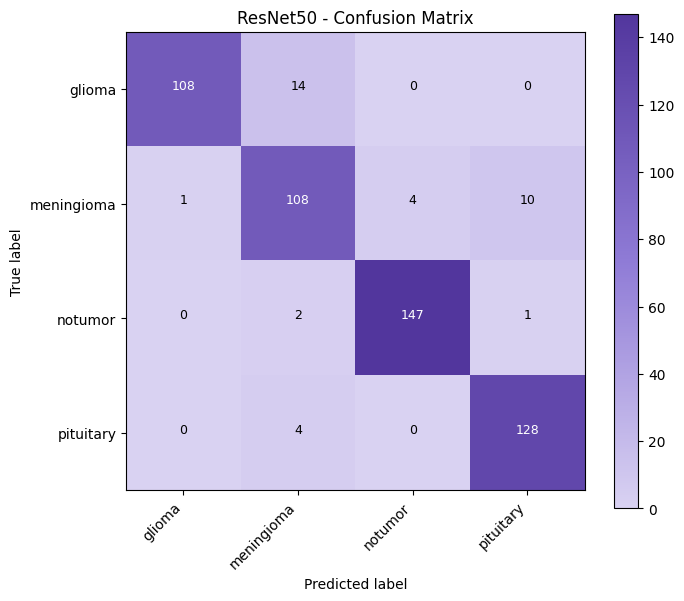


ResNet50 - Confusion Matrix
              precision    recall  f1-score   support

      glioma       0.99      0.89      0.94       122
  meningioma       0.84      0.88      0.86       123
     notumor       0.97      0.98      0.98       150
   pituitary       0.92      0.97      0.94       132

    accuracy                           0.93       527
   macro avg       0.93      0.93      0.93       527
weighted avg       0.93      0.93      0.93       527



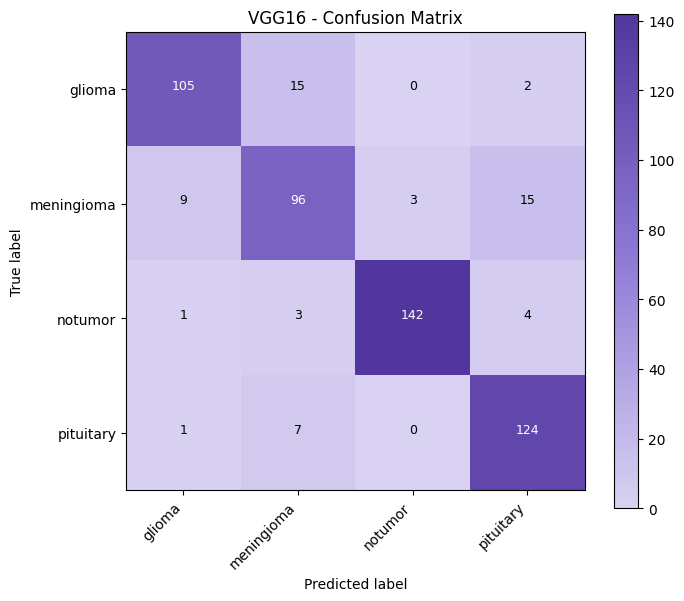


VGG16 - Confusion Matrix
              precision    recall  f1-score   support

      glioma       0.91      0.86      0.88       122
  meningioma       0.79      0.78      0.79       123
     notumor       0.98      0.95      0.96       150
   pituitary       0.86      0.94      0.90       132

    accuracy                           0.89       527
   macro avg       0.88      0.88      0.88       527
weighted avg       0.89      0.89      0.89       527



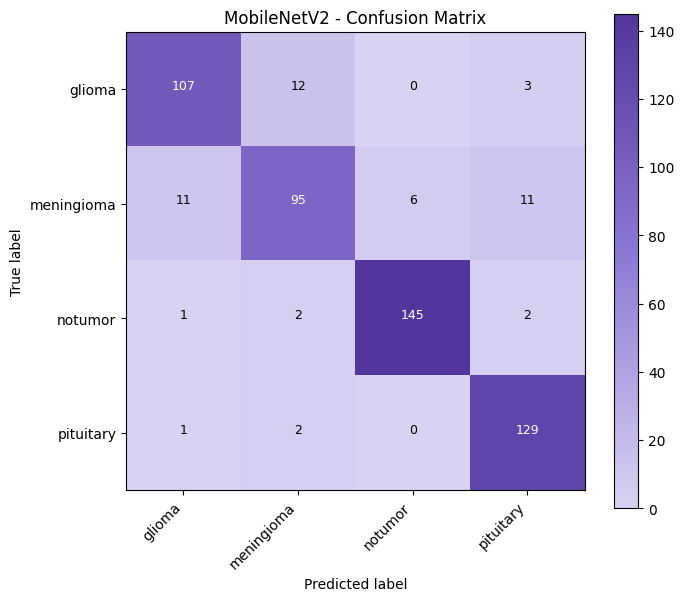


MobileNetV2 - Confusion Matrix
              precision    recall  f1-score   support

      glioma       0.89      0.88      0.88       122
  meningioma       0.86      0.77      0.81       123
     notumor       0.96      0.97      0.96       150
   pituitary       0.89      0.98      0.93       132

    accuracy                           0.90       527
   macro avg       0.90      0.90      0.90       527
weighted avg       0.90      0.90      0.90       527



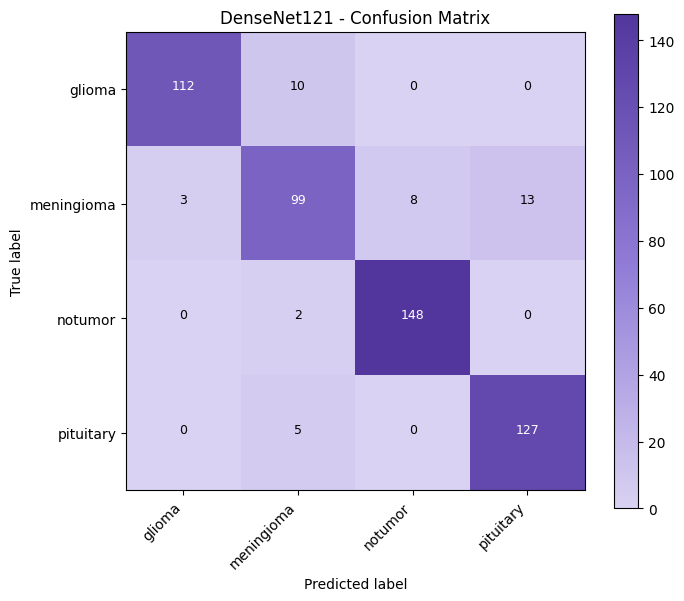


DenseNet121 - Confusion Matrix
              precision    recall  f1-score   support

      glioma       0.97      0.92      0.95       122
  meningioma       0.85      0.80      0.83       123
     notumor       0.95      0.99      0.97       150
   pituitary       0.91      0.96      0.93       132

    accuracy                           0.92       527
   macro avg       0.92      0.92      0.92       527
weighted avg       0.92      0.92      0.92       527

 Saved confusion matrices in: /content/drive/MyDrive/brain_tumor_models/confusion_matrices_20260107-163831


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib.colors import LinearSegmentedColormap

#  Purple-only colormap (light -> dark)
PURPLE_CMAP = LinearSegmentedColormap.from_list(
    "purple_only",
    ["#d9d2f2", "#8f7bd6", "#52369d"],  # light -> mid -> dark (your purple)
    N=256
)

def plot_and_save_cm(model, gen, class_names, title, out_path):
    y_true = gen.classes
    y_prob = model.predict(gen, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(7, 6))
    plt.imshow(cm, interpolation='nearest', cmap=PURPLE_CMAP)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha='right')
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
            fontsize=9
        )

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.show()

    print("\n" + "="*60)
    print(title)
    print(classification_report(y_true, y_pred, target_names=class_names))


from google.colab import drive
drive.mount('/content/drive')

CM_DIR = f"/content/drive/MyDrive/brain_tumor_models/confusion_matrices_{run_id}"
os.makedirs(CM_DIR, exist_ok=True)

plot_and_save_cm(base_model,   test_gen,        class_names, "Base CNN - Confusion Matrix",    os.path.join(CM_DIR, "cm_base_cnn.png"))
plot_and_save_cm(resnet_model, resnet_test_gen, class_names, "ResNet50 - Confusion Matrix",    os.path.join(CM_DIR, "cm_resnet50.png"))
plot_and_save_cm(vgg_model,    vgg_test_gen,    class_names, "VGG16 - Confusion Matrix",       os.path.join(CM_DIR, "cm_vgg16.png"))
plot_and_save_cm(mn_model,     mn_test_gen,     class_names, "MobileNetV2 - Confusion Matrix", os.path.join(CM_DIR, "cm_mobilenetv2.png"))
plot_and_save_cm(dn_model,     dn_test_gen,     class_names, "DenseNet121 - Confusion Matrix", os.path.join(CM_DIR, "cm_densenet121.png"))

print(" Saved confusion matrices in:", CM_DIR)

# XAI — LIME

In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

def load_raw_image(img_path, target_size=(256, 256)):
    img_pil = Image.open(img_path).convert("RGB").resize(target_size)
    img_np = np.array(img_pil)  # uint8
    return img_pil, img_np

idx2class = {v: k for k, v in test_gen.class_indices.items()}

img_index = 100
img_path = test_gen.filepaths[img_index]
true_label = idx2class[test_gen.classes[img_index]]

orig_pil, raw_img = load_raw_image(img_path)

print(" Path:", img_path)
print(" True:", true_label)


 Path: /content/brain-tumor-mri-dataset/Training/glioma/Tr-gl_0742.jpg
 True: glioma


LIME helper + Base CNN

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━

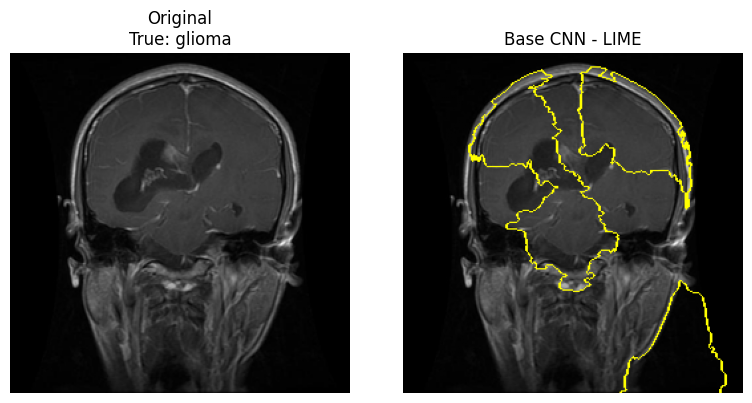

In [ ]:
explainer = lime_image.LimeImageExplainer()

def lime_explain(raw_img, predict_fn, title):
    explanation = explainer.explain_instance(
        image=raw_img,
        classifier_fn=predict_fn,
        top_labels=1,
        hide_color=0,
        num_samples=1000
    )
    top_label = explanation.top_labels[0]
    temp, mask = explanation.get_image_and_mask(
        top_label, positive_only=True, num_features=5, hide_rest=False
    )

    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1); plt.imshow(orig_pil); plt.axis("off"); plt.title(f"Original\nTrue: {true_label}")
    plt.subplot(1,2,2); plt.imshow(mark_boundaries(temp/255.0, mask)); plt.axis("off"); plt.title(title)
    plt.tight_layout()
    plt.show()

def base_predict_fn(images):
    imgs = np.array(images).astype("float32") / 255.0
    return base_model.predict(imgs)

lime_explain(raw_img, base_predict_fn, "Base CNN - LIME")


LIME — ResNet50 / VGG16 / MobileNetV2 / DenseNet121

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━

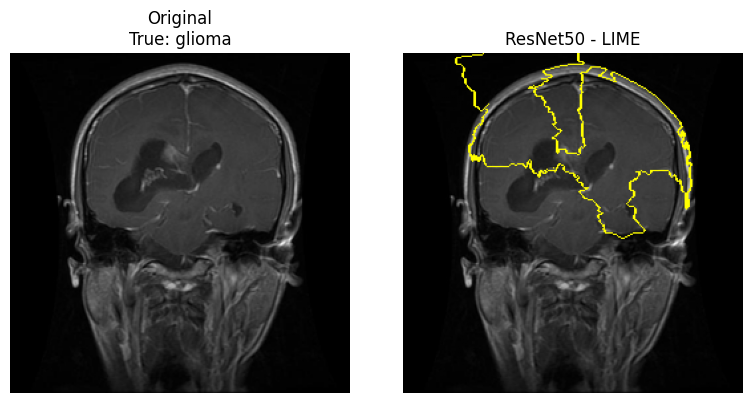

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━

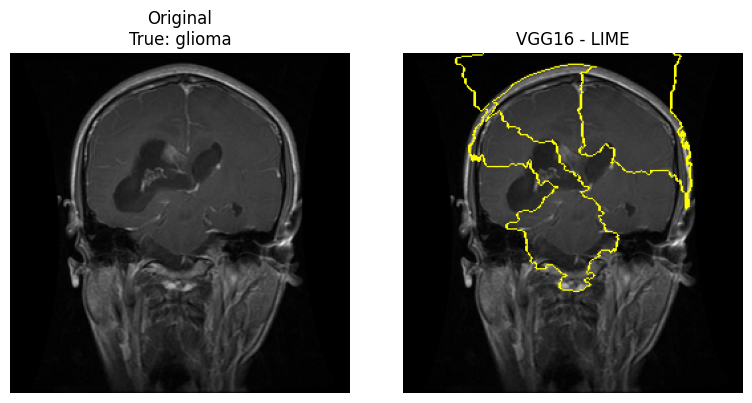

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━

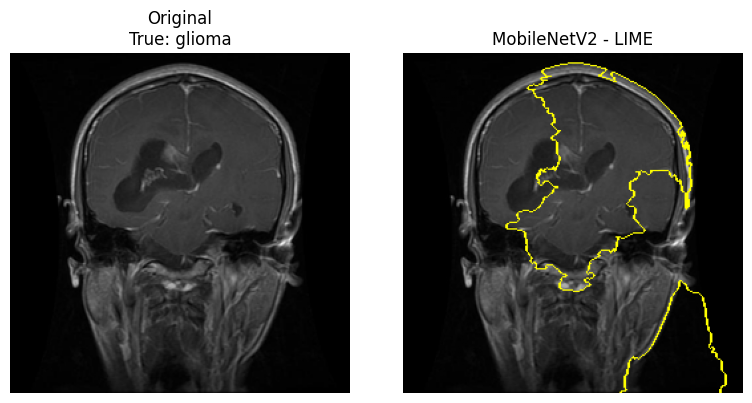

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━

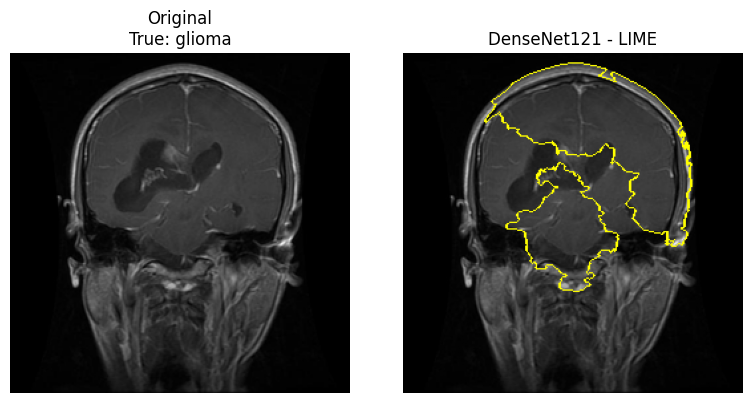

In [ ]:
def predict_with_preprocess(images, preprocess_fn, model):
    processed = []
    for img in images:
        pil = Image.fromarray(img.astype("uint8")).resize((256, 256))
        arr = np.array(pil).astype("float32")
        arr = preprocess_fn(arr)
        processed.append(arr)
    processed = np.stack(processed)
    return model.predict(processed)

lime_explain(raw_img, lambda imgs: predict_with_preprocess(imgs, resnet_preprocess, resnet_model), "ResNet50 - LIME")
lime_explain(raw_img, lambda imgs: predict_with_preprocess(imgs, vgg_preprocess,   vgg_model),   "VGG16 - LIME")
lime_explain(raw_img, lambda imgs: predict_with_preprocess(imgs, mn_preprocess,    mn_model),    "MobileNetV2 - LIME")
lime_explain(raw_img, lambda imgs: predict_with_preprocess(imgs, dn_preprocess,    dn_model),    "DenseNet121 - LIME")


XAI — SHAP (Image masker)

  0%|          | 0/2998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:17, 17.51s/it]               


 Base CNN - SHAP


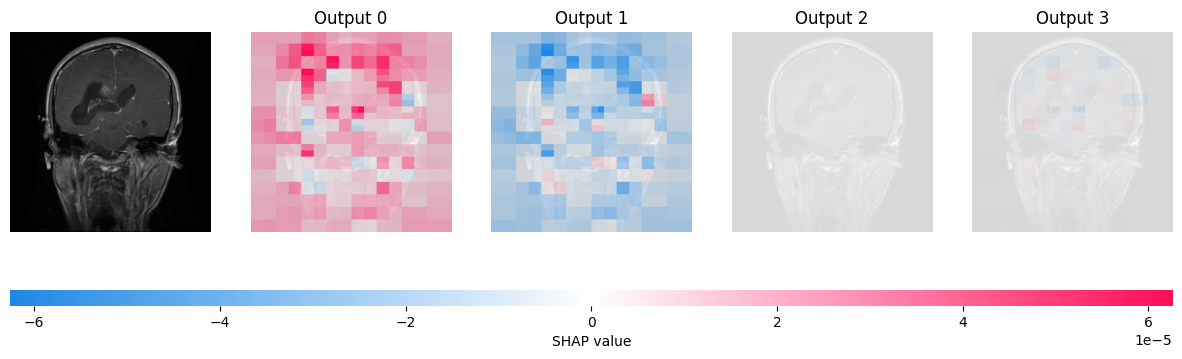

  0%|          | 0/2998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:16, 76.89s/it]               


 ResNet50 - SHAP


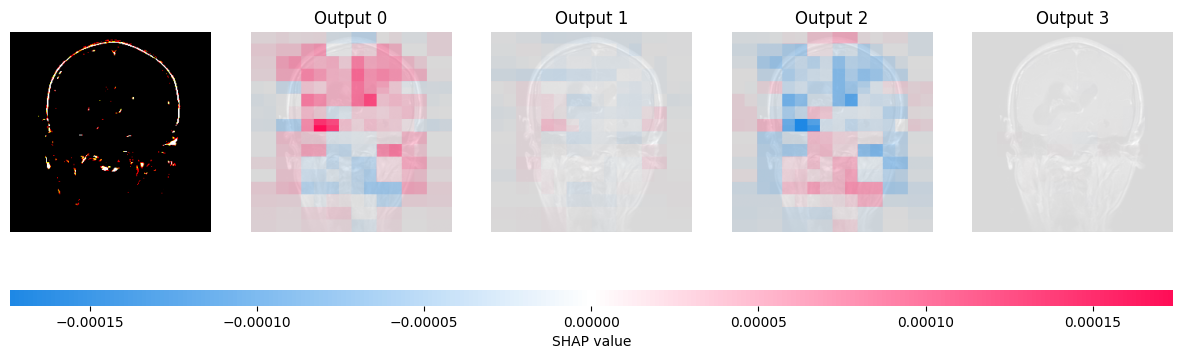

  0%|          | 0/2998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:19, 19.94s/it]               


 VGG16 - SHAP


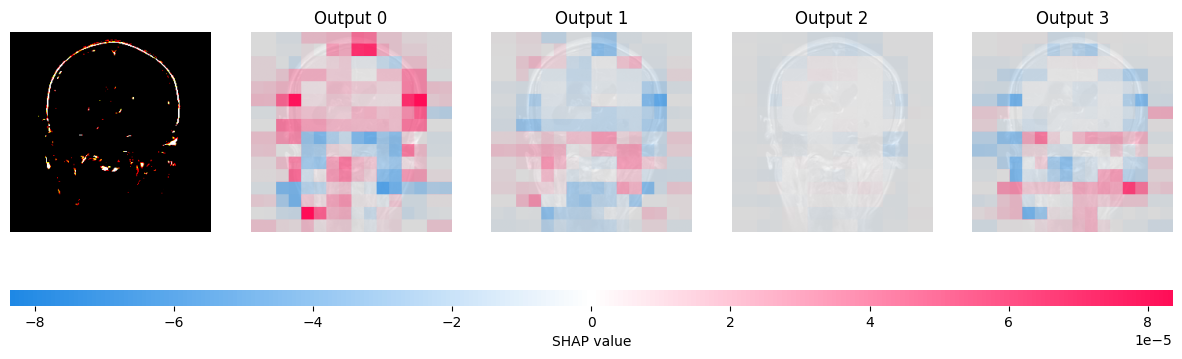

  0%|          | 0/2998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:51, 51.31s/it]               


 MobileNetV2 - SHAP


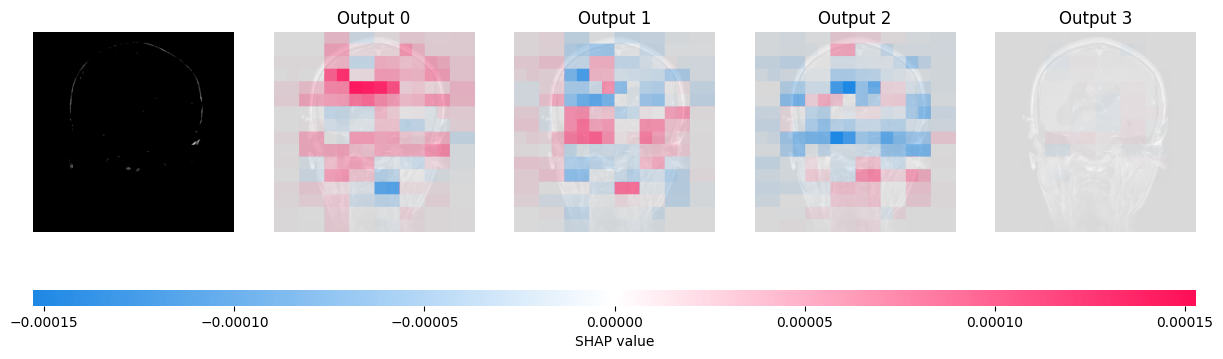

  0%|          | 0/2998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [02:21, 141.25s/it]              


 DenseNet121 - SHAP


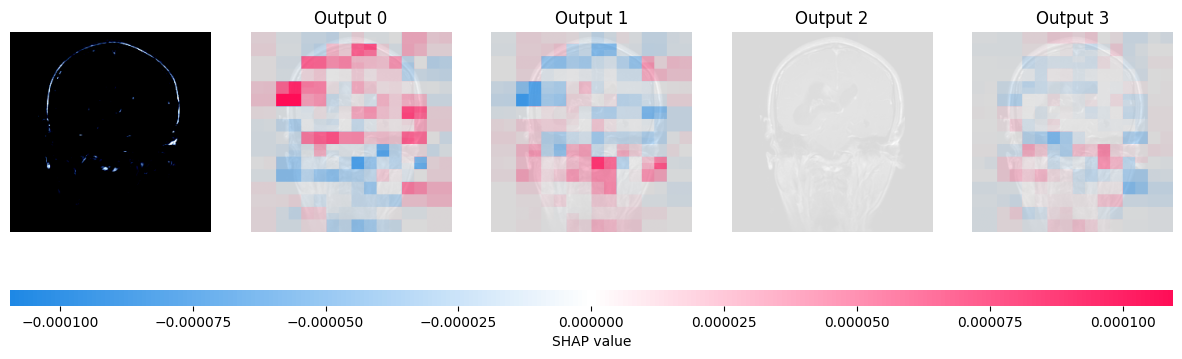

In [ ]:
import shap

def preprocess_image_for_shap(image_path, mode="base"):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [256, 256])
    img = tf.cast(img, tf.float32)

    if mode == "base":
        img = img / 255.0
    elif mode == "resnet":
        img = resnet_preprocess(img)
    elif mode == "vgg":
        img = vgg_preprocess(img)
    elif mode == "mn":
        img = mn_preprocess(img)
    elif mode == "dn":
        img = dn_preprocess(img)
    else:
        raise ValueError("Unknown mode")
    return img.numpy()

def shap_explain(model, img_arr, title):
    def f(x):
        x = tf.convert_to_tensor(x, dtype=tf.float32)
        return model(x).numpy()

    masker = shap.maskers.Image("blur(256,256)", shape=img_arr.shape)
    explainer = shap.Explainer(f, masker)

    shap_values = explainer(
        img_arr[np.newaxis, ...],
        max_evals=3000,
        outputs=shap.Explanation.argsort.flip[:4]
    )
    print("", title)
    shap.image_plot(shap_values)

# base
img_base = preprocess_image_for_shap(img_path, "base")
shap_explain(base_model, img_base, "Base CNN - SHAP")

# pretrained
img_r = preprocess_image_for_shap(img_path, "resnet")
shap_explain(resnet_model, img_r, "ResNet50 - SHAP")

img_v = preprocess_image_for_shap(img_path, "vgg")
shap_explain(vgg_model, img_v, "VGG16 - SHAP")

img_m = preprocess_image_for_shap(img_path, "mn")
shap_explain(mn_model, img_m, "MobileNetV2 - SHAP")

img_d = preprocess_image_for_shap(img_path, "dn")
shap_explain(dn_model, img_d, "DenseNet121 - SHAP")


  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:23, 23.59s/it]               

Base CNN - SHAP


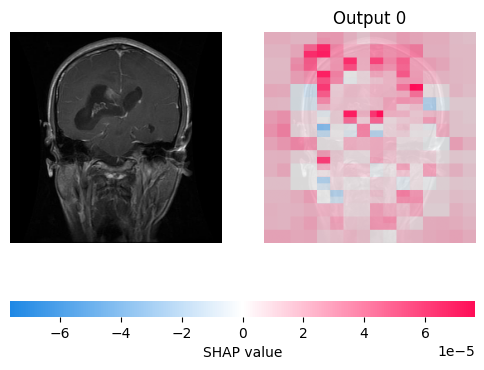

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [02:06, 126.45s/it]              

ResNet50 - SHAP


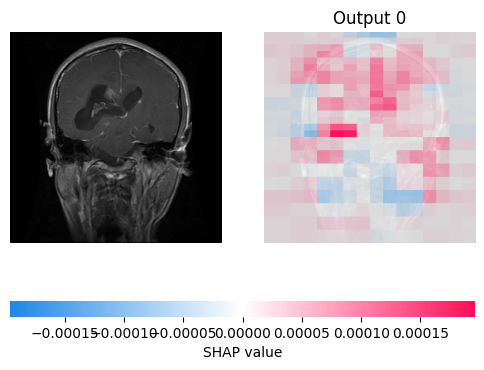

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.56s/it]               

VGG16 - SHAP


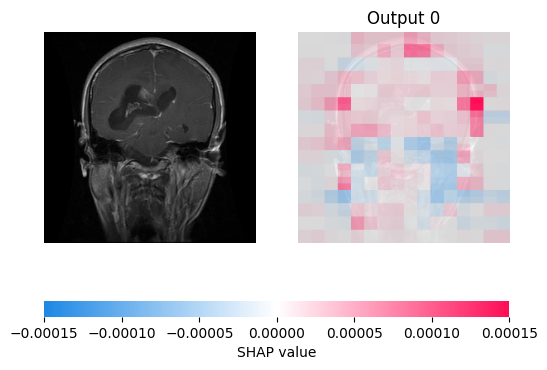

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:22, 82.98s/it]               

MobileNetV2 - SHAP


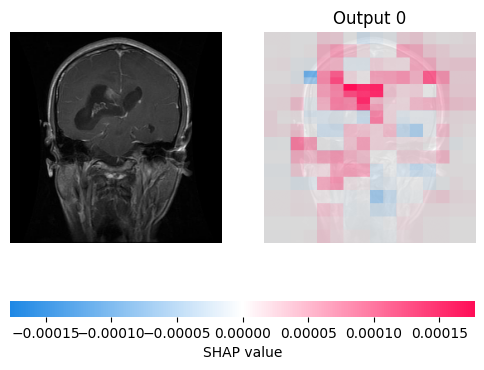

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [03:49, 229.62s/it]              

DenseNet121 - SHAP


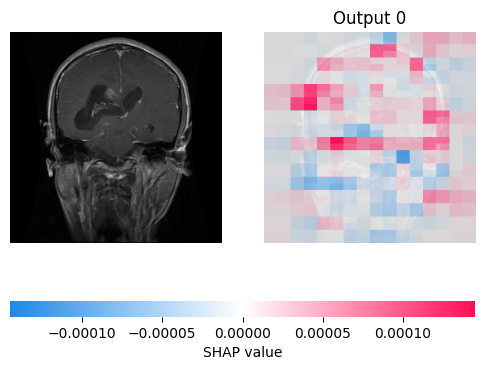

In [ ]:
import shap
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array

def load_image_two_versions(image_path, target_size=(256,256), mode="base"):
    # نسخة للعرض (0..1)
    img = load_img(image_path, target_size=target_size)
    img_disp = img_to_array(img).astype("float32") / 255.0  # for plotting

    # نسخة للموديل
    img_model = img_to_array(img).astype("float32")
    if mode == "base":
        img_model = img_model / 255.0
    elif mode == "resnet":
        img_model = resnet_preprocess(img_model)
    elif mode == "vgg":
        img_model = vgg_preprocess(img_model)
    elif mode == "mn":
        img_model = mn_preprocess(img_model)
    elif mode == "dn":
        img_model = dn_preprocess(img_model)
    else:
        raise ValueError("Unknown mode")

    return img_disp, img_model

def shap_explain_clean(model, img_disp, img_model, title, top_k=1, max_evals=5000):
    def f(x):
        x = tf.convert_to_tensor(x, dtype=tf.float32)
        return model(x).numpy()

    masker = shap.maskers.Image("blur(256,256)", img_model.shape)
    explainer = shap.Explainer(f, masker)

    # لو تبغى فقط Top class بدل 4 outputs (يطلع أوضح غالباً)
    if top_k == 1:
        y = model(tf.convert_to_tensor(img_model[np.newaxis,...], dtype=tf.float32)).numpy()
        top_class = int(np.argmax(y, axis=1)[0])
        outputs = [top_class]
    else:
        outputs = shap.Explanation.argsort.flip[:top_k]

    shap_values = explainer(
        img_model[np.newaxis, ...],
        max_evals=max_evals,
        outputs=outputs
    )

    print(title)
    shap.image_plot(shap_values, pixel_values=img_disp[np.newaxis, ...])

# ====== Usage ======
img_disp, img_model = load_image_two_versions(img_path, (256,256), mode="base")
shap_explain_clean(base_model, img_disp, img_model, "Base CNN - SHAP", top_k=1)

img_disp, img_model = load_image_two_versions(img_path, (256,256), mode="resnet")
shap_explain_clean(resnet_model, img_disp, img_model, "ResNet50 - SHAP", top_k=1)

img_disp, img_model = load_image_two_versions(img_path, (256,256), mode="vgg")
shap_explain_clean(vgg_model, img_disp, img_model, "VGG16 - SHAP", top_k=1)

img_disp, img_model = load_image_two_versions(img_path, (256,256), mode="mn")
shap_explain_clean(mn_model, img_disp, img_model, "MobileNetV2 - SHAP", top_k=1)

img_disp, img_model = load_image_two_versions(img_path, (256,256), mode="dn")
shap_explain_clean(dn_model, img_disp, img_model, "DenseNet121 - SHAP", top_k=1)

# XAI — Grad-CAM

In [ ]:
for l in reversed(resnet_model.layers):
    if isinstance(l, tf.keras.Model):
        print("Backbone layer name inside full model:", l.name)
        # print last few layers inside backbone
        print("Last 10 backbone layers:")
        for x in l.layers[-10:]:
            print(" -", x.name, type(x).__name__)
        break

Backbone layer name inside full model: resnet50
Last 10 backbone layers:
 - conv5_block3_1_conv Conv2D
 - conv5_block3_1_bn BatchNormalization
 - conv5_block3_1_relu Activation
 - conv5_block3_2_conv Conv2D
 - conv5_block3_2_bn BatchNormalization
 - conv5_block3_2_relu Activation
 - conv5_block3_3_conv Conv2D
 - conv5_block3_3_bn BatchNormalization
 - conv5_block3_add Add
 - conv5_block3_out Activation


In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array

# ====== 1) Sanity checks ======
print("img_path =", img_path)
print("run_id   =", run_id)

if img_path is None:
    raise ValueError("❌ img_path is None. Please set img_path to a valid image path.")

# ====== 2) Load image safely ======
img_pil = load_img(img_path, target_size=(256, 256))
img_arr = img_to_array(img_pil)

print("img_arr type:", type(img_arr), "shape:", getattr(img_arr, "shape", None), "dtype:", getattr(img_arr, "dtype", None))

if img_arr is None:
    raise ValueError("❌ img_arr is None (unexpected). Something is wrong with image loading.")

# ====== 3) Manual ResNet50 preprocessing INLINE (never returns None) ======
x_np = img_arr.astype("float32").copy()

# RGB -> BGR
x_np = x_np[..., ::-1]

# subtract ImageNet means (caffe mode)
x_np[..., 0] -= 103.939
x_np[..., 1] -= 116.779
x_np[..., 2] -= 123.68

print("x_np type:", type(x_np), "shape:", x_np.shape, "dtype:", x_np.dtype)

# ====== 4) Convert to tensor safely ======
x = tf.constant(x_np[np.newaxis, ...], dtype=tf.float32)
print("x tensor shape:", x.shape, "dtype:", x.dtype)

# If we reached here => NO None problem anymore
print(" Preprocessing OK. Tensor created successfully.")

img_path = /content/brain-tumor-mri-dataset/Training/glioma/Tr-gl_0742.jpg
run_id   = 20260107-163831
img_arr type: <class 'numpy.ndarray'> shape: (256, 256, 3) dtype: float32
x_np type: <class 'numpy.ndarray'> shape: (256, 256, 3) dtype: float32
x tensor shape: (1, 256, 256, 3) dtype: <dtype: 'float32'>
 Preprocessing OK. Tensor created successfully.


 Saved: /content/drive/MyDrive/brain_tumor_models/gradcam_20260107-163831/gradcam_resnet50.png


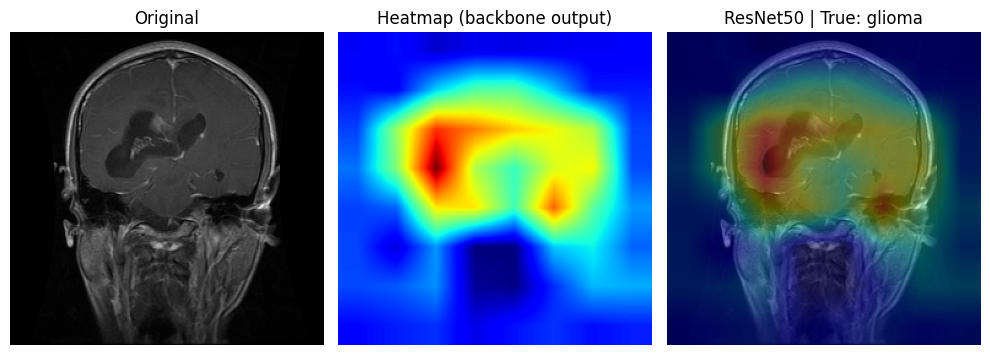

 Grad-CAM saved in: /content/drive/MyDrive/brain_tumor_models/gradcam_20260107-163831


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array

# Manual ResNet50 preprocess (never returns None)
def preprocess_resnet50_manual(img_rgb_float):
    x = img_rgb_float.astype("float32")
    x = x[..., ::-1]  # RGB -> BGR
    x[..., 0] -= 103.939
    x[..., 1] -= 116.779
    x[..., 2] -= 123.68
    return x

def gradcam_resnet50_head_safe(
    img_path,
    resnet_model,
    backbone_layer_name="resnet50",
    title="",
    alpha=0.35,
    save_path=None,
    target_size=(256, 256),
    cmap="jet"
):
    # 1) Load image for display
    img_pil = load_img(img_path, target_size=target_size)
    img_arr = img_to_array(img_pil).astype("float32")

    # 2) Preprocess for ResNet50 (manual)
    x_np = preprocess_resnet50_manual(img_arr.copy())
    x = tf.constant(x_np[np.newaxis, ...], dtype=tf.float32)

    # 3) Extract backbone (nested model layer inside resnet_model)
    backbone = resnet_model.get_layer(backbone_layer_name)

    # 4) Collect head layers AFTER backbone
    head_layers = []
    found = False
    for layer in resnet_model.layers:
        if layer.name == backbone_layer_name:
            found = True
            continue
        if found:
            head_layers.append(layer)

    # 5) Build a clean functional graph
    inp = tf.keras.Input(shape=(target_size[0], target_size[1], 3))

    #  conv_maps = backbone output (this is conv5_block3_out effectively)
    conv_maps = backbone(inp, training=False)

    # preds depends on conv_maps directly
    z = conv_maps
    for layer in head_layers:
        z = layer(z, training=False)
    preds = z

    grad_model = tf.keras.Model(inputs=inp, outputs=[conv_maps, preds])

    # 6) Grad-CAM
    with tf.GradientTape() as tape:
        conv_out, predictions = grad_model(x, training=False)
        pred_index = tf.argmax(predictions[0])
        class_score = predictions[:, pred_index]

    grads = tape.gradient(class_score, conv_out)

    #  If grads is None -> graph not connected (should not happen now)
    if grads is None:
        raise RuntimeError(
            "grads is None. This means predictions do not depend on conv_out."
        )

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_out = conv_out[0]  # (H,W,C)
    heatmap = tf.matmul(conv_out, pooled_grads[..., tf.newaxis])
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    heatmap = heatmap.numpy()

    # 7) Resize heatmap to image size
    heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], target_size).numpy().squeeze()

    # 8) Plot
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 3, 1); plt.imshow(img_pil); plt.axis("off"); plt.title("Original")
    plt.subplot(1, 3, 2); plt.imshow(heatmap_resized, cmap=cmap); plt.axis("off"); plt.title("Heatmap (backbone output)")
    plt.subplot(1, 3, 3); plt.imshow(img_pil); plt.imshow(heatmap_resized, cmap=cmap, alpha=alpha); plt.axis("off"); plt.title(title)
    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(" Saved:", save_path)

    plt.show()
    return int(pred_index.numpy())


# ===== Run & Save =====
GC_DIR = f"/content/drive/MyDrive/brain_tumor_models/gradcam_{run_id}"
os.makedirs(GC_DIR, exist_ok=True)

_ = gradcam_resnet50_head_safe(
    img_path=img_path,
    resnet_model=resnet_model,
    backbone_layer_name="resnet50",
    title=f"ResNet50 | True: {true_label}",
    alpha=0.35,
    save_path=os.path.join(GC_DIR, "gradcam_resnet50.png"),
    cmap="jet"
)

print(" Grad-CAM saved in:", GC_DIR)


In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.utils import load_img, img_to_array
from matplotlib.colors import LinearSegmentedColormap

# Purple theme colormap (light -> dark)
PURPLE_CMAP = LinearSegmentedColormap.from_list(
    "purple_theme",
    ["#efe9ff", "#b79cff", "#52369d"],
    N=256
)

print(" Imports + purple cmap ready")

 Imports + purple cmap ready


In [ ]:
print("img_path:", img_path)
print("exists?:", os.path.exists(img_path))
print("run_id:", run_id)

assert os.path.exists(img_path), "❌ img_path غير صحيح أو الملف غير موجود"
print(" Sanity checks passed")


img_path: /content/brain-tumor-mri-dataset/Training/glioma/Tr-gl_0742.jpg
exists?: True
run_id: 20260107-163831
 Sanity checks passed


In [ ]:
def safe_preprocess(img_arr_float32, preprocess_fn):
    """
    Some preprocess functions might modify in-place and return None.
    This keeps it safe.
    """
    x0 = img_arr_float32.copy()
    out = preprocess_fn(x0)
    if out is None:
        out = x0
    return out

def get_nested_backbone_layer(full_model):
    """
    Returns first nested tf.keras.Model layer (backbone) if exists, else None.
    Pretrained models in your setup have a nested backbone.
    Base CNN does not.
    """
    for layer in full_model.layers:
        if isinstance(layer, tf.keras.Model):
            return layer
    return None

def find_last_conv2d_layer_name(model):
    """
    For base CNN sequential: find last Conv2D layer name.
    """
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    # fallback if nested
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.Model):
            for sub in reversed(layer.layers):
                if isinstance(sub, tf.keras.layers.Conv2D):
                    return sub.name
    raise ValueError("No Conv2D layer found")

print(" Helpers ready")


 Helpers ready


In [ ]:
def gradcam_unified(
    img_path,
    model,
    preprocess_fn,
    class_names=None,
    title_prefix="",
    alpha=0.35,
    save_path=None,
    target_size=(256, 256),
    cmap=PURPLE_CMAP
):
    # ---- Load image ----
    img_pil = load_img(img_path, target_size=target_size)
    img_arr = img_to_array(img_pil).astype("float32")

    # ---- Preprocess ----
    x_np = safe_preprocess(img_arr, preprocess_fn)
    x = tf.constant(x_np[np.newaxis, ...], dtype=tf.float32)

    # ---- Detect if model has nested backbone ----
    backbone = get_nested_backbone_layer(model)

    inp = tf.keras.Input(shape=(target_size[0], target_size[1], 3))

    if backbone is not None:
        # ==============================
        # PRETRAINED MODELS PATH
        # ==============================
        backbone_name = backbone.name

        # collect head layers after backbone
        head_layers = []
        found = False
        for layer in model.layers:
            if layer.name == backbone_name:
                found = True
                continue
            if found:
                head_layers.append(layer)

        #  conv_maps = backbone output (connected to preds)
        conv_maps = backbone(inp, training=False)

        z = conv_maps
        for layer in head_layers:
            z = layer(z, training=False)
        preds = z

        layer_used = f"backbone output ({backbone_name})"
        grad_model = tf.keras.Model(inputs=inp, outputs=[conv_maps, preds])

    else:
        # ==============================
        # BASE CNN PATH (Sequential)
        # ==============================
        last_conv_name = find_last_conv2d_layer_name(model)

        # Build graph
        preds = model(inp, training=False)

        # Feature extractor: inp -> last conv output (Keras3 safe)
        feature_extractor = tf.keras.Model(
            inputs=inp,
            outputs=model.get_layer(last_conv_name).output
        )

        conv_maps = feature_extractor.output
        layer_used = f"last conv ({last_conv_name})"

        grad_model = tf.keras.Model(inputs=inp, outputs=[conv_maps, preds])

    # ---- Grad-CAM ----
    with tf.GradientTape() as tape:
        conv_out, predictions = grad_model(x, training=False)
        pred_index = tf.argmax(predictions[0])
        class_score = predictions[:, pred_index]

    grads = tape.gradient(class_score, conv_out)
    if grads is None:
        raise RuntimeError("❌ grads is None (predictions not dependent on conv_out)")

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_out0 = conv_out[0]
    heatmap = tf.matmul(conv_out0, pooled_grads[..., tf.newaxis])
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    heatmap = heatmap.numpy()

    heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], target_size).numpy().squeeze()

    pred_idx_int = int(pred_index.numpy())
    pred_label = class_names[pred_idx_int] if class_names is not None else str(pred_idx_int)

    # ---- Plot ----
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(img_pil)
    plt.axis("off")
    plt.title("Original")

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap_resized, cmap=cmap)
    plt.axis("off")
    plt.title(f"Heatmap\n{layer_used}")

    plt.subplot(1, 3, 3)
    plt.imshow(img_pil)
    plt.imshow(heatmap_resized, cmap=cmap, alpha=alpha)
    plt.axis("off")
    plt.title(f"{title_prefix}\nPred: {pred_label}")

    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(" Saved:", save_path)

    plt.show()

    return pred_idx_int, layer_used

print(" gradcam_unified ready")


 gradcam_unified ready


In [ ]:
def gradcam_unified(
    img_path,
    model,
    preprocess_fn,
    class_names=None,
    title_prefix="",
    alpha=0.35,
    save_path=None,
    target_size=(256, 256),
    cmap=PURPLE_CMAP
):
    # ---- Load image ----
    img_pil = load_img(img_path, target_size=target_size)
    img_arr = img_to_array(img_pil).astype("float32")

    # ---- Preprocess ----
    x_np = safe_preprocess(img_arr, preprocess_fn)
    x = tf.constant(x_np[np.newaxis, ...], dtype=tf.float32)

    backbone = get_nested_backbone_layer(model)
    inp = tf.keras.Input(shape=(target_size[0], target_size[1], 3))

    if backbone is not None:
        # ==============================
        # PRETRAINED MODELS PATH
        # ==============================
        backbone_name = backbone.name

        head_layers = []
        found = False
        for layer in model.layers:
            if layer.name == backbone_name:
                found = True
                continue
            if found:
                head_layers.append(layer)

        conv_maps = backbone(inp, training=False)
        z = conv_maps
        for layer in head_layers:
            z = layer(z, training=False)
        preds = z

        layer_used = f"backbone output ({backbone_name})"
        grad_model = tf.keras.Model(inputs=inp, outputs=[conv_maps, preds])

    else:
        # ==============================
        # BASE CNN PATH (Sequential)  NO .output usage
        # ==============================
        z = inp
        conv_tensor = None
        conv_layer_name = None

        # pass through layers manually and capture last Conv2D tensor
        for layer in model.layers:
            z = layer(z, training=False)
            if isinstance(layer, tf.keras.layers.Conv2D):
                conv_tensor = z
                conv_layer_name = layer.name

        if conv_tensor is None:
            raise ValueError("No Conv2D found in base_model")

        preds = z
        conv_maps = conv_tensor
        layer_used = f"last conv ({conv_layer_name})"

        grad_model = tf.keras.Model(inputs=inp, outputs=[conv_maps, preds])

    # ---- Grad-CAM ----
    with tf.GradientTape() as tape:
        conv_out, predictions = grad_model(x, training=False)
        pred_index = tf.argmax(predictions[0])
        class_score = predictions[:, pred_index]

    grads = tape.gradient(class_score, conv_out)
    if grads is None:
        raise RuntimeError("❌ grads is None (predictions not dependent on conv_out)")

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_out0 = conv_out[0]
    heatmap = tf.matmul(conv_out0, pooled_grads[..., tf.newaxis])
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    heatmap = heatmap.numpy()

    heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], target_size).numpy().squeeze()

    pred_idx_int = int(pred_index.numpy())
    pred_label = class_names[pred_idx_int] if class_names is not None else str(pred_idx_int)

    # ---- Plot ----
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(img_pil); plt.axis("off"); plt.title("Original")

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap_resized, cmap=cmap); plt.axis("off")
    plt.title(f"Heatmap\n{layer_used}")

    plt.subplot(1, 3, 3)
    plt.imshow(img_pil)
    plt.imshow(heatmap_resized, cmap=cmap, alpha=alpha)
    plt.axis("off")
    plt.title(f"{title_prefix}\nPred: {pred_label}")

    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(" Saved:", save_path)

    plt.show()

    return pred_idx_int, layer_used


GC_DIR: /content/drive/MyDrive/brain_tumor_models/gradcam_20260107-163831
 Saved: /content/drive/MyDrive/brain_tumor_models/gradcam_20260107-163831/gradcam_base.png


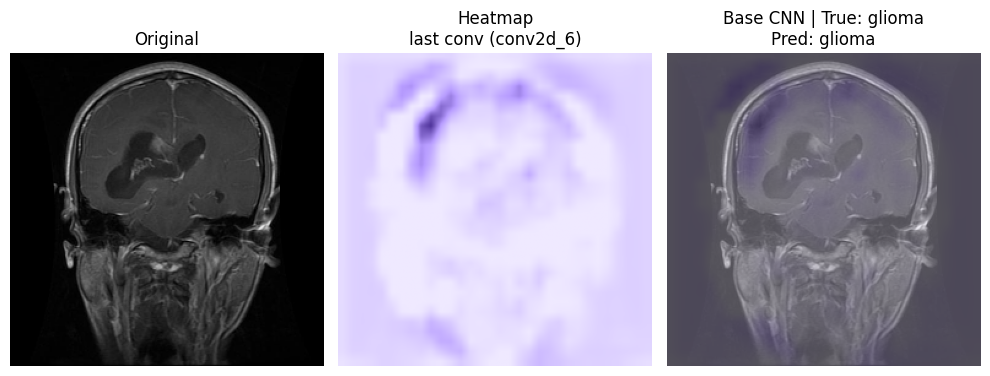

 Base CNN done: 0 last conv (conv2d_6)
 Saved: /content/drive/MyDrive/brain_tumor_models/gradcam_20260107-163831/gradcam_resnet50.png


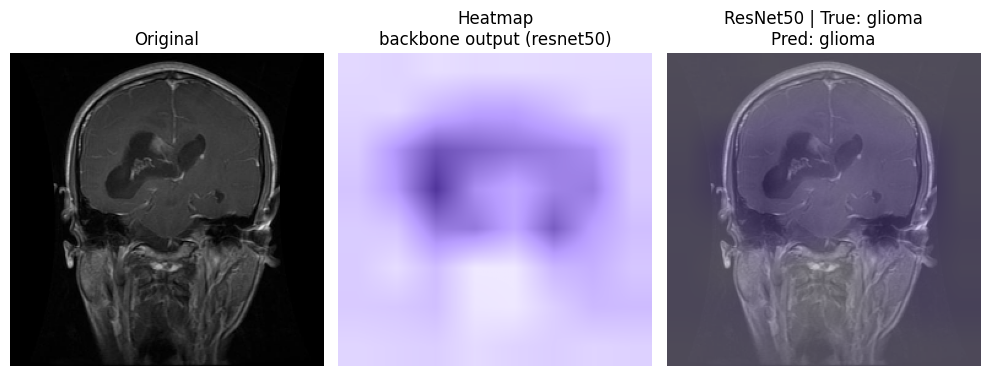

 ResNet50 done: 0 backbone output (resnet50)
 Saved: /content/drive/MyDrive/brain_tumor_models/gradcam_20260107-163831/gradcam_vgg16.png


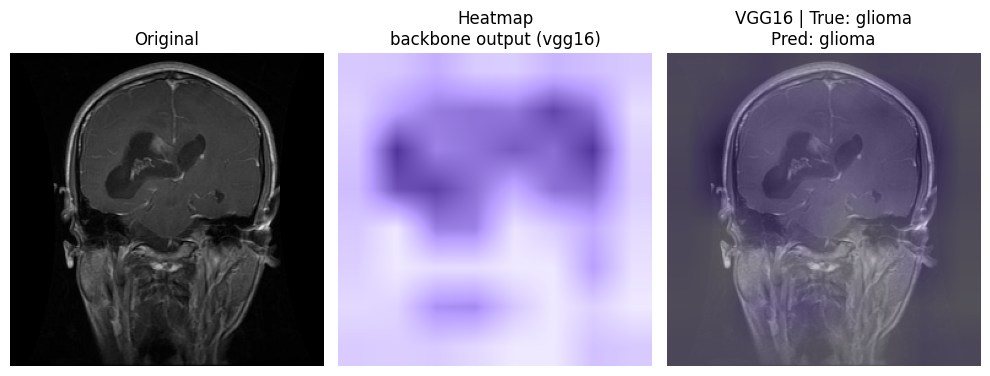

 VGG16 done: 0 backbone output (vgg16)
 Saved: /content/drive/MyDrive/brain_tumor_models/gradcam_20260107-163831/gradcam_mobilenetv2.png


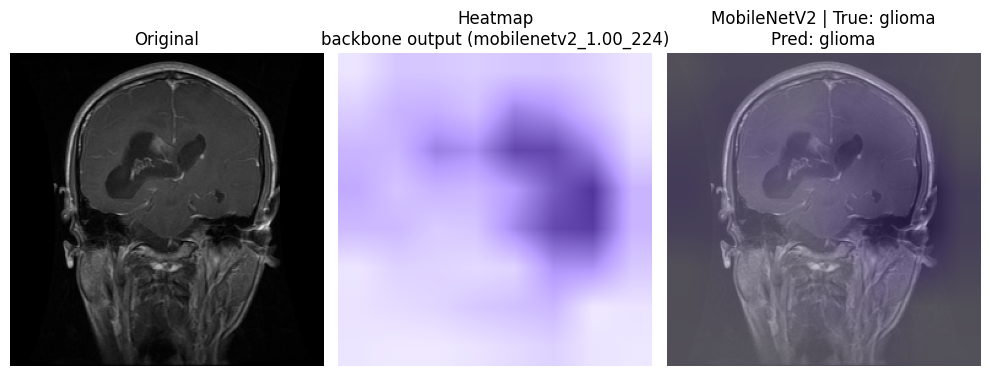

 MobileNetV2 done: 0 backbone output (mobilenetv2_1.00_224)
 Saved: /content/drive/MyDrive/brain_tumor_models/gradcam_20260107-163831/gradcam_densenet121.png


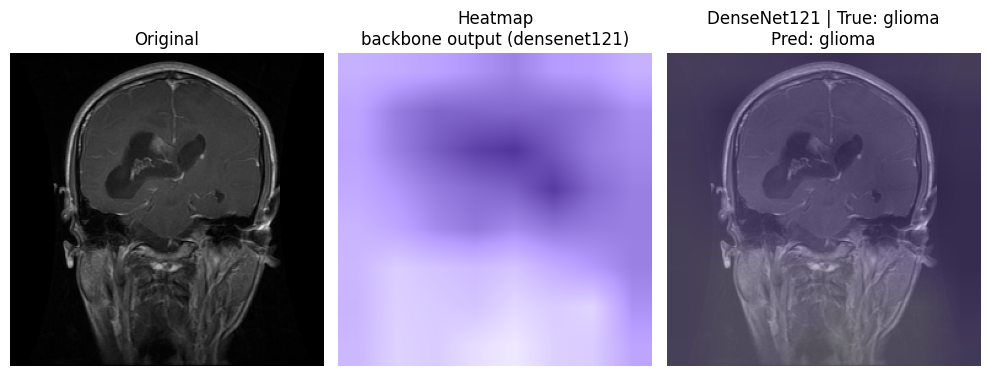

 DenseNet121 done: 0 backbone output (densenet121)
 All Grad-CAM saved in: /content/drive/MyDrive/brain_tumor_models/gradcam_20260107-163831


In [ ]:
GC_DIR = f"/content/drive/MyDrive/brain_tumor_models/gradcam_{run_id}"
os.makedirs(GC_DIR, exist_ok=True)
print("GC_DIR:", GC_DIR)

# Base CNN
pred_idx, layer_used = gradcam_unified(
    img_path, base_model,
    preprocess_fn=lambda a: a/255.0,
    class_names=class_names,
    title_prefix=f"Base CNN | True: {true_label}",
    save_path=os.path.join(GC_DIR, "gradcam_base.png"),
    alpha=0.35
)
print(" Base CNN done:", pred_idx, layer_used)

# ResNet50
pred_idx, layer_used = gradcam_unified(
    img_path, resnet_model,
    preprocess_fn=resnet_preprocess,
    class_names=class_names,
    title_prefix=f"ResNet50 | True: {true_label}",
    save_path=os.path.join(GC_DIR, "gradcam_resnet50.png"),
    alpha=0.35
)
print(" ResNet50 done:", pred_idx, layer_used)

# VGG16
pred_idx, layer_used = gradcam_unified(
    img_path, vgg_model,
    preprocess_fn=vgg_preprocess,
    class_names=class_names,
    title_prefix=f"VGG16 | True: {true_label}",
    save_path=os.path.join(GC_DIR, "gradcam_vgg16.png"),
    alpha=0.35
)
print(" VGG16 done:", pred_idx, layer_used)

# MobileNetV2
pred_idx, layer_used = gradcam_unified(
    img_path, mn_model,
    preprocess_fn=mn_preprocess,
    class_names=class_names,
    title_prefix=f"MobileNetV2 | True: {true_label}",
    save_path=os.path.join(GC_DIR, "gradcam_mobilenetv2.png"),
    alpha=0.35
)
print(" MobileNetV2 done:", pred_idx, layer_used)

# DenseNet121
pred_idx, layer_used = gradcam_unified(
    img_path, dn_model,
    preprocess_fn=dn_preprocess,
    class_names=class_names,
    title_prefix=f"DenseNet121 | True: {true_label}",
    save_path=os.path.join(GC_DIR, "gradcam_densenet121.png"),
    alpha=0.35
)
print(" DenseNet121 done:", pred_idx, layer_used)

print(" All Grad-CAM saved in:", GC_DIR)


Save Models (Unique names)

In [ ]:
MODELS_DIR = "/content/drive/MyDrive/brain_tumor_models/models_" + run_id
os.makedirs(MODELS_DIR, exist_ok=True)

def save_model_unique(m, base_name, ext="keras"):
    filename = f"{base_name}_{run_id}.{ext}"
    path = os.path.join(MODELS_DIR, filename)
    m.save(path)
    print(" Saved:", path)
    return path

# Save current final models
save_model_unique(base_model,   "base_cnn",      ext="h5")
save_model_unique(resnet_model, "resnet50",      ext="keras")
save_model_unique(vgg_model,    "vgg16",         ext="keras")
save_model_unique(mn_model,     "mobilenetv2",   ext="keras")
save_model_unique(dn_model,     "densenet121",   ext="keras")

# Also copy best checkpoints created by ModelCheckpoint (if exist)
for fn in [f"best_base_cnn_{run_id}.h5", resnet_ckpt_path, vgg_ckpt_path, mn_ckpt_path, dn_ckpt_path]:
    if os.path.exists(fn):
        shutil.copy2(fn, os.path.join(MODELS_DIR, os.path.basename(fn)))
        print(" Copied checkpoint:", fn)

print("\n Files in:", MODELS_DIR)
for f in sorted(os.listdir(MODELS_DIR)):
    print(" -", f)

# Save class indices
with open(os.path.join(MODELS_DIR, f"class_indices_{run_id}.json"), "w") as f:
    json.dump(train_gen.class_indices, f)
print(" class indices saved")


 Saved: /content/drive/MyDrive/brain_tumor_models/models_20260107-163831/base_cnn_20260107-163831.h5
 Saved: /content/drive/MyDrive/brain_tumor_models/models_20260107-163831/resnet50_20260107-163831.keras
 Saved: /content/drive/MyDrive/brain_tumor_models/models_20260107-163831/vgg16_20260107-163831.keras
 Saved: /content/drive/MyDrive/brain_tumor_models/models_20260107-163831/mobilenetv2_20260107-163831.keras
 Saved: /content/drive/MyDrive/brain_tumor_models/models_20260107-163831/densenet121_20260107-163831.keras
 Copied checkpoint: best_base_cnn_20260107-163831.h5
 Copied checkpoint: best_resnet50_20260107-163831.keras
 Copied checkpoint: best_vgg16_20260107-163831.keras
 Copied checkpoint: best_mobilenetv2_20260107-163831.keras
 Copied checkpoint: best_densenet121_20260107-163831.keras

 Files in: /content/drive/MyDrive/brain_tumor_models/models_20260107-163831
 - base_cnn_20260107-163831.h5
 - base_cnn_20260107-163831.keras
 - best_base_cnn_20260107-163831.h5
 - best_base_cnn_20260

In [ ]:
save_model_unique(base_model, "base_cnn", ext="keras")


 Saved: /content/drive/MyDrive/brain_tumor_models/models_20260107-163831/base_cnn_20260107-163831.keras


'/content/drive/MyDrive/brain_tumor_models/models_20260107-163831/base_cnn_20260107-163831.keras'

In [ ]:
# If you want to copy best_base checkpoint and also save a .keras version:
best_h5 = f"best_base_cnn_{run_id}.h5"
if os.path.exists(best_h5):
    tmp = tf.keras.models.load_model(best_h5)
    tmp.save(os.path.join(MODELS_DIR, f"best_base_cnn_{run_id}.keras"))
    print(" Saved best_base as .keras too")

 Saved best_base as .keras too
